In [1]:
import tensorflow as tf
import struct
import numpy as np
from matplotlib import pyplot
import matplotlib as mpl

Define function for loading MNIST images and labels.

In [2]:
def load_files(label_path,img_path):
    """
    load MNIST images and labels:
    params: label path and image path
    returns: returns 2 numpy arrays containing images (28 x 28) and labels (1 to 9)
    
    """
    with open(label_path, 'rb') as f_label:
        _,_ = struct.unpack(">II", f_label.read(8))
        labels = np.fromfile(f_label, dtype=np.int8)
    
    with open(img_path, 'rb') as f_img:
        _,_, rows, cols = struct.unpack(">IIII", f_img.read(16))
        imgs = np.fromfile(f_img, dtype=np.uint8).reshape(len(labels), rows, cols)
    
    return imgs,labels

load train and test data

In [3]:
trainImgs,trainLabels = load_files('data/train-labels.idx1-ubyte','data/train-images.idx3-ubyte')
testImgs, testLabels = load_files('data/t10k-labels.idx1-ubyte','data/t10k-images.idx3-ubyte')

Split the test set into validation and hold out test set.

In [4]:
classDict = {}
print(testImgs.shape, testLabels.shape)
classes = np.unique(testLabels)
valLabels = np.array([], dtype=np.int64).reshape(0,1)
newtestLabels = np.array([], dtype=np.int64).reshape(0,1)
newtestImgs = np.array([], dtype=np.int64).reshape(0,1,28,28)
valImgs = np.array([], dtype=np.int64).reshape(0,1,28,28)
for class_ in classes:
    indices = np.argwhere(testLabels == class_)
    np.random.shuffle(indices)
    val_indices = indices[:int(len(indices) * 0.5)]
    test_indices = indices[int(len(indices) * 0.5):]
    valLabels = np.concatenate((valLabels,testLabels[val_indices]), axis=0)
    valImgs = np.concatenate((valImgs,testImgs[val_indices]), axis=0)
    newtestLabels = np.concatenate((newtestLabels,testLabels[test_indices]), axis=0)
    newtestImgs = np.concatenate((newtestImgs,testImgs[test_indices]), axis=0)
valLabels = np.squeeze(valLabels)
valImgs = np.squeeze(valImgs)
testLabels = np.squeeze(newtestLabels)
testImgs = np.squeeze(newtestImgs)
print(valImgs.shape,valLabels.shape)
print(testImgs.shape,testLabels.shape)

(10000, 28, 28) (10000,)
(4999, 28, 28) (4999,)
(5001, 28, 28) (5001,)


In [5]:
def show(imgs,labels):
    """
    plot sample images for each class (0 to 9) for the given distribution set.
    params: imgs: images in the form of numpy arrays
    params: labels: labels of the raw images
    returns: 
    
    """
    classes = np.unique(labels)
    counter = 1
    fig = pyplot.figure(figsize=(15,15))
    for class_ in classes:
        indices = np.argwhere(labels == class_).reshape(-1)
        random_index = np.random.choice(indices, 1)
        ax = fig.add_subplot(1,10,counter)
        ax.imshow(imgs[random_index[0]], cmap=mpl.cm.Greys)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        counter += 1
    pyplot.subplots_adjust(wspace=0.05)
    pyplot.show()


Training data (Random Image samples)


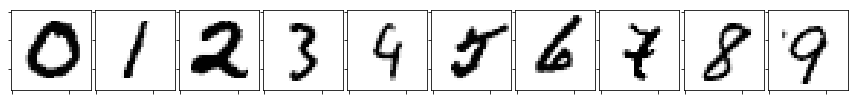

Validation data (Random Image samples)


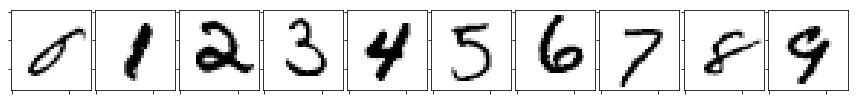

Testing data (Random Image samples)


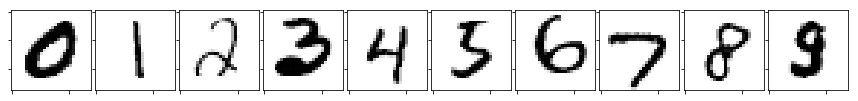

In [6]:
print('Training data (Random Image samples)')
show(trainImgs,trainLabels)
print('Validation data (Random Image samples)')
show(valImgs, valLabels)
print('Testing data (Random Image samples)')
show(testImgs, testLabels)

In [7]:
def one_hot_encoding(y):
    """
    Generate one-hot-ecoding for the labels:
    params: list of labels: y
    returns: numpy array of encoded labels of size [?,num_classes]
    
    """
    num_samples = y.shape[0]
    print(y.shape)
    num_class = np.unique(y).shape[0]   
    num_class = 10    
    y_encoded = np.zeros((num_samples,num_class))
    y_encoded[np.arange(num_samples),y] = 1

    return y_encoded

Convert to one-hot-encoded labels.

In [8]:
trainLabels = one_hot_encoding(trainLabels)
testLabels =  one_hot_encoding(testLabels)
valLabels = one_hot_encoding(valLabels)

(60000,)
(5001,)
(4999,)


In [9]:
def create_model_inputs(n_W,n_H,n_y):
    """
    Define model inputs based on dimensions provided.
    params: n_W: width of the input
    params: n_h: height of the input
    params: n_y: number of labels for the distribution
    returns: tensor placeholder objects
    
    """
    X = tf.placeholder(tf.float32, shape=[None,n_W,n_H])
    Y = tf.placeholder(tf.float32, shape=[None,n_y])
    
    return X,Y

In [30]:
def random_mini_batches(X,Y,minibatch_size,seed=3):
    """
    Function to split data into random mini batches
    params: X: width of the input
    params: Y: height of the input
    params: minibatch: number of labels for the distribution
    params: minibatch_size: number of labels for the distribution
    returns: list of minibatches for the data
    
    """
    np.random.seed(seed)
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    minibatches = []
    for idx in range(0,num_samples,minibatch_size):
        
        minibatch_idices = indices[idx:idx+minibatch_size]
        minibatches.append((X[minibatch_idices,:,:],
                              Y[minibatch_idices,:]))
    return minibatches

In [31]:
def initialize_parameters():
    """
    initialize weights of the CNN.
    returns: dictionary consisting of weights for each CNN layer.
    
    """
    tf.set_random_seed(1)
    
    filter_height = {"l1": 10, "l2": 10, "l3": 10 }
    filter_width = {"l1" : 10, "l2": 10, "l3" : 10}
    in_channels = {"l1" : 1,"l2" : 16, "l3" : 32, "l4": 1024}
    out_channels = {"l1" : 16,"l2" : 32,"l3" : 64, "l4" : 10}
    
    init = tf.contrib.layers.xavier_initializer(seed = 0)
    bias_init = tf.constant_initializer(0.0)
    
    W1 = tf.get_variable("W1",[filter_height["l1"],filter_width["l1"],in_channels["l1"],out_channels["l1"]],initializer=init)
    W2 = tf.get_variable("W2",[filter_height["l2"],filter_width["l2"],in_channels["l2"],out_channels["l2"]],initializer=init)
    W3 = tf.get_variable("W3",[filter_height["l3"],filter_width["l3"],in_channels["l3"],out_channels["l3"]],initializer=init)
    W4 = tf.get_variable("W4",[in_channels["l4"],out_channels["l4"]],initializer=init) 
    
    bias1 = tf.get_variable("bias1",out_channels["l1"],initializer=bias_init)
    bias2 = tf.get_variable("bias2",out_channels["l2"],initializer=bias_init)
    bias3 = tf.get_variable("bias3",out_channels["l3"],initializer=bias_init)
    bias4 = tf.get_variable("bias4",out_channels["l4"],initializer=bias_init)
    
    parameters = {"W1":W1,"W2":W2,"W3":W3,"W4":W4,
                  "bias1":bias1,"bias2":bias2,"bias3":bias3,"bias4":bias4}
    
    return parameters

In [32]:
# tf.reset_default_graph()
# initialize_parameters()

In [33]:
def forward_propagation(X,parameters,keep_prob):
    """
    CNN architecture 
    params: X: raw input data (images)
    params: Y: initialized weights of the CNN architecture
    params: keep_prob: Fraction of neurons to be kept (dropout rate)
    returns: output of the CNN (values of 10 output neurons representing probabilities of each class). 
    
    """
    X = tf.reshape(X, [-1, 28, 28, 1])  # reshape to (?,28,28,1) 
    
    W1,bias1 = parameters["W1"], parameters["bias1"]
    W2,bias2 = parameters["W2"], parameters["bias2"]
    W3,bias3 = parameters["W3"], parameters["bias3"]
    W4,bias4 = parameters["W4"], parameters["bias4"]
    
    Z1 = tf.nn.conv2d(X,W1,strides=[1, 1, 1, 1],padding='SAME') + bias1
    A1 = tf.nn.relu(Z1)
    D1 = tf.nn.dropout(A1,keep_prob)
    P1 = tf.nn.max_pool(D1, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    Z2 = tf.nn.conv2d(P1,W2,strides=[1, 1, 1, 1],padding='SAME') + bias2
    A2 = tf.nn.relu(Z2)
    D2 = tf.nn.dropout(A2,keep_prob)
    P2 = tf.nn.max_pool(D2, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    Z3 = tf.nn.conv2d(P2,W3,strides=[1, 1, 1, 1],padding='SAME') + bias3
    A3 = tf.nn.relu(Z3)
    D3 = tf.nn.dropout(A3,keep_prob)
    P3 = tf.nn.max_pool(A3, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    
    P3 = tf.contrib.layers.flatten(P3)

    #Z3 = tf.contrib.layers.fully_connected(P3, num_outputs=10, activation_fn=None)
    Z3 = tf.matmul(P3,W4) + bias4
    
    return Z3

In [34]:
def compute_cost(prediction,actual):
    """
    params: actual labels
    params: predicted probabilites
    returns: softmax cross entropy cost between the actual and predicted distribution. 
    
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=actual))        
    return cost 

In [35]:
def model_train(train_data,val_data,num_epochs=20,learning_rate=0.001,minibatch_size=128):
    """
    
    Training the CNN for fixed number of epochs.
    
    params: training data: tuple of X [?,784] and Y [?,10]
            validation data: tuple of X [?,784] and Y [?,10]
            number of epochs (max): int   
            learning rate (alpha): float
            minibatch size: int
    returns: val_loss_list: List of loss for validation set for training period (<=num_epochs)
             train_loss_list: List of loss for training set for training period (<=num_epochs)
             parameters: learned weights for the network (Variable tensor object)
             sess: current session object. 
    
    """
    tf.reset_default_graph() # reset
    
    X_train , y_train = train_data
    X_val , y_val = val_data
    
    X_in,y_in = create_model_inputs(28,28,10)   # define placeholders
    keep_prob = tf.placeholder(tf.float32)
    parameters = initialize_parameters() # define model parameters
    
    prediction  = forward_propagation(X_in,parameters,keep_prob) # feed-forward
    
    loss = compute_cost(prediction,y_in)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss) # back-prop
    
    # accuracy prediction
    label_predictions = tf.argmax(prediction,1)
    true_predictions = tf.equal(label_predictions,tf.argmax(y_in,1))
    correct_predictions = tf.reduce_sum(tf.cast(true_predictions,"float"))
    accuracy = tf.reduce_mean(tf.cast(true_predictions,"float"))
    
    train_loss_list = []
    val_loss_list = []
    
    # create and initialize variables through tensorflow session object.
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    # Training for num_epochs
    for epoch in range(num_epochs):
            
        train_loss = 0            
        minibatches = random_mini_batches(X_train,y_train,minibatch_size)
        num_minibatches = int (X_train.shape[0] / minibatch_size)
        
        # Train for minibatch
        right_predictions = 0
        for minibatch in minibatches:
            X_minibatch , y_minibatch = minibatch
                
            _, minibatch_loss,true_predictions = sess.run([optimizer, loss, correct_predictions], feed_dict={X_in:X_minibatch,y_in:y_minibatch,keep_prob:0.90}) # feed inputs 
                   
            train_loss += minibatch_loss / num_minibatches 
            right_predictions += true_predictions
        
        train_acc = right_predictions/X_train.shape[0]
        val_loss,val_acc = sess.run([loss,accuracy], feed_dict={X_in:X_val,y_in:y_val,keep_prob:1.0})
            
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
            
        print(('epoch %i: train_loss: %f  train_acc: %f, val_loss: %f val_acc: %f' 
               %(epoch+1,train_loss,train_acc,val_loss,val_acc)))
         
    return train_loss_list,val_loss_list,parameters,sess
        

In [45]:
train_data = (trainImgs,trainLabels)
val_data = (valImgs, valLabels)
train_loss_list,val_loss_list,parameters,sess = model_train(train_data,val_data,num_epochs=5,learning_rate=0.001,minibatch_size=128)

epoch 1: train_loss: 0.413582  train_acc: 0.921600, val_loss: 0.065285 val_acc: 0.977996
epoch 2: train_loss: 0.068759  train_acc: 0.978617, val_loss: 0.060464 val_acc: 0.979596
epoch 3: train_loss: 0.049343  train_acc: 0.984733, val_loss: 0.054442 val_acc: 0.982797
epoch 4: train_loss: 0.046731  train_acc: 0.985633, val_loss: 0.060666 val_acc: 0.979796
epoch 5: train_loss: 0.039069  train_acc: 0.988250, val_loss: 0.051474 val_acc: 0.983797


In [46]:
def plot_loss(train_loss,val_loss):
    """
    Plot of training and validation loss.
    params:  val_loss_list: List of loss for validation set for training period (<=num_epochs)
             train_loss_list: List of loss for training set for training period (<=num_epochs)
    returns: None

    """
    pyplot.plot(np.squeeze(train_loss),label='training')
    pyplot.plot(np.squeeze(val_loss),label='validation')
    pyplot.xlabel('epochs')
    pyplot.ylabel('loss')
    pyplot.title('Model Performance')
    pyplot.legend()
    pyplot.show()

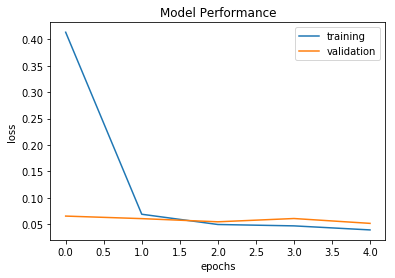

In [47]:
plot_loss(train_loss_list,val_loss_list)

In [48]:
def model_test(test_data,best_parameters,sess):
    """
    Model evalution for the test set,
    params:  sess: default tensorflow session object.
    params:  test_data: tuple of X (features) and y(labels) 
    params:  best_parameters: final model parameters (weights).
    returns: Accuracy on the test data.

    """
    X_test, y_test = test_data

    X_in,y_in = create_model_inputs(28,28,10) 
    keep_prob = tf.placeholder(tf.float32)
    prediction  = forward_propagation(X_in,best_parameters,keep_prob)

    
    label_predictions = tf.argmax(prediction,1)
    true_predictions = tf.equal(label_predictions,tf.argmax(y_in,1))
    accuracy = tf.reduce_mean(tf.cast(true_predictions,"float"))
    
    acc = sess.run(accuracy, feed_dict={X_in:X_test,y_in:y_test,keep_prob:1.0})
    
    return acc

In [49]:
test_data = (testImgs, testLabels)
print(model_test(test_data,parameters,sess))

0.988602
